In [3]:
import numpy as np
import matplotlib.pyplot as plt
from activelabeling.kernel import Kernel

In [4]:
%load_ext autoreload
%autoreload 2

In [6]:
%matplotlib inline
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{newtxmath}') 
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times"

## Setup

In [4]:
def eta_bumps(x, epsilon=.01):
    y = np.empty(len(x), dtype=float)
    y[x <= .5] = 1
    y[(x > .5) & (x <= 1)] = epsilon
    y[(x > 1) & (x <= 2.5)] = -epsilon
    y[x > 2.5] = -1
    return y

In [5]:
n = 500
x_train = np.hstack((np.linspace(0, 1, num=n//2), np.linspace(2, 3, num=n//2)))
y_train = eta_bumps(x_train)
y_proba = (y_train + 1) / 2

x = np.hstack((x_train, x_train))[:, np.newaxis]
y = np.hstack((np.ones(len(x_train)), -np.ones(len(x_train))))
w = np.hstack((y_proba, 1 - y_proba))

/var/folders/yg/djxj05p562nc92kcrz6sfj3c0000gn/T/ipykernel_45407/3399563618.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


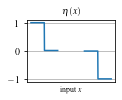

In [6]:
fig, axis = plt.subplots(1, 1, figsize=(1.8, 1.5))

axis.plot(x_train[:n//2], y_train[:n//2], c='C0')
axis.plot(x_train[n//2:], y_train[n//2:], c='C0')
axis.set_title(r"$\eta(x)$", fontsize=10)
axis.set_xticks([])
axis.grid()
axis.set_xlabel(r'input $x$', fontsize=8)
fig.tight_layout()
fig.show()
# fig.savefig('noisy_class.pdf')

## Training

In [7]:
sigma = .1
lambd = 1e-2

kernel = Kernel('gaussian', sigma=.1)
kernel.set_support(x_train[:, np.newaxis])
K = kernel(x_train[:, np.newaxis])

In [8]:
alpha_krr = np.linalg.solve(K + lambd * n * np.eye(n), y_train)

In [9]:
alpha = np.zeros(n, dtype=float)
average_alpha = np.zeros(n, dtype=float)

def get_stepsize(T, gamma_0=1):
    gamma = np.arange(T, dtype=float)
    gamma += 1
    np.power(gamma, -1/2, out=gamma)
    gamma *= gamma_0
    return gamma

n_steps = int(1e6)
gamma = get_stepsize(n_steps, 1)
error = np.zeros(n_steps)
error_min = (np.abs(np.sign(y_train) - 1) * y_proba).mean()
error_min += (np.abs(np.sign(y_train) + 1) * (1 - y_proba)).mean()

tmp, tmp_grad = np.empty(n, dtype=float), np.empty(n, dtype=float)

for i in range(n_steps):
    tmp[:] = K @ alpha 
    error[i] += (np.abs(tmp - 1) * y_proba).mean()
    error[i] += (np.abs(tmp + 1) * (1 - y_proba)).mean()
    error[i] += lambd * (alpha.T @ tmp)

    tmp_grad[:] = 0
    tmp_grad += np.sign(tmp - 1) * y_proba
    tmp_grad += np.sign(tmp + 1) * (1 - y_proba)
    grad = K @ tmp_grad
    tmp *= 2 * n * lambd
    grad += tmp
    grad /= n
    alpha -= gamma[i] * grad

    average_alpha += alpha
    if not (i % (n_steps // 30)):
        tmp[:] = K @ average_alpha / (i+1)
        err = (np.abs(tmp - 1) * y_proba).mean()
        err += (np.abs(tmp + 1) * (1 - y_proba)).mean()
        err += lambd * (average_alpha.T @ tmp) / (i+1)
        print(i, np.abs(alpha).mean(), err - error_min)

0 0.05803018706633908 4.316160217384923
33333 0.013287287121923242 0.06520623722084673
66666 0.014085471997273348 0.06394781495423885
99999 0.014684736114815201 0.06342218038399261
133332 0.015387008668813009 0.06312186646912477
166665 0.01599004347922727 0.06291117044980454
199998 0.016628521348225834 0.06274868626331198
233331 0.017103580296566754 0.06262291660959818
266664 0.017536188602753678 0.06252403886579982
299997 0.017855994574031413 0.06244314992969224
333330 0.0181790049511083 0.06237466054759555
366663 0.01843725999380357 0.062315572102812355
399996 0.01869269194202024 0.062264317767031785
433329 0.01889080794317347 0.06221919497842343
466662 0.019098965499205308 0.06217872802059221
499995 0.01926080926765681 0.062142619306577496
533328 0.019433875132313268 0.06210998326516903
566661 0.01957488425586272 0.06208037568466507
599994 0.019727397561249412 0.06205363037896505
633327 0.019846984199227823 0.06202959662191454
666660 0.019976155776054556 0.062007558398870066
699993 

## Testing

In [11]:
z_krr = kernel(x_train[:, np.newaxis]).T @ alpha_krr
x_comp = np.linspace(1, 2)
k_comp = kernel(x_comp[:, np.newaxis])
z_comp_krr = k_comp.T @ alpha_krr
z = K @ average_alpha / n_steps
z_comp = k_comp.T @ average_alpha / n_steps

Text(0.5, 1.0, 'Training error')

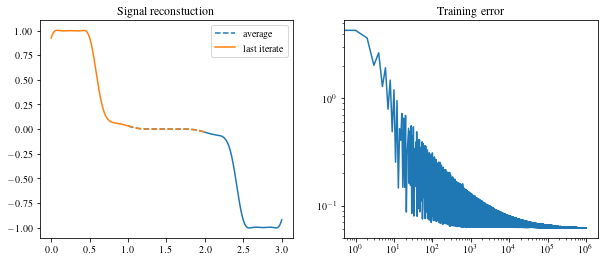

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
# ax1.plot(x_train[:n//2], z[:n//2], c='C0')
a, = ax1.plot(x_comp, z_comp, c='C0', ls='--')
ax1.plot(x_train[n//2:], z[n//2:], c='C0')
z_bis = K @ alpha
z_bis_comp = k_comp.T @ alpha
b, = ax1.plot(x_train[:n//2], z_bis[:n//2], c='C1')
ax1.plot(x_comp, z_bis_comp, c='C1', ls='--')
# ax1.plot(x_train[n//2:], z[n//2:], c='C1')
ax1.legend([a, b], ['average', 'last iterate'])
ax1.set_title('Signal reconstuction')
ax2.plot(error - error_min)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title('Training error')

/var/folders/yg/djxj05p562nc92kcrz6sfj3c0000gn/T/ipykernel_45407/827642478.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


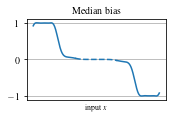

In [13]:
fig, axis = plt.subplots(1, 1, figsize=(2.5, 1.75))

axis.plot(x_train[:n//2], z[:n//2], c='C0')
axis.plot(x_comp, z_comp, c='C0', ls='--')
axis.plot(x_train[n//2:], z[n//2:], c='C0')
axis.set_title(r"Median bias", fontsize=10)
axis.set_xticks([])
axis.set_xlabel(r'input $x$', fontsize=8)
axis.grid()
fig.tight_layout()
fig.show()
# fig.savefig('noisy_median_bis.pdf')


/var/folders/yg/djxj05p562nc92kcrz6sfj3c0000gn/T/ipykernel_45407/3574256898.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


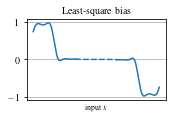

In [14]:
fig, axis = plt.subplots(1, 1, figsize=(2.5, 1.75))

axis.plot(x_train[:n//2], z_krr[:n//2], c='C0')
axis.plot(x_comp, z_comp_krr, c='C0', ls='--')
axis.plot(x_train[n//2:], z_krr[n//2:], c='C0')
axis.set_title(r"Least-square bias", fontsize=10)
axis.set_xticks([])
axis.set_xlabel(r'input $x$', fontsize=8)
axis.grid()
fig.tight_layout()
fig.show()
# fig.savefig('noisy_ls_bis.pdf')
